In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qclab.simulation as simulation
from qclab.models.spin_boson import SpinBosonModel
from qclab.algorithms.mf import MeanFieldDynamics
from qclab.algorithms.fssh import FewestSwitchesSurfaceHoppingDynamics
from qclab.algorithms.cfssh import CoherentFewestSwitchesSurfaceHoppingDynamics
from qclab.drivers.ray_driver import dynamics_parallel_ray

In [2]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)

sim.num_trajs = 20
sim.tmax=int(1/0.0260677)+1
sim.dt_output=0.01
sim.dt=1/(10*sim.w[-1])

sim.wf_db = np.zeros((sim.num_states),dtype=complex)
sim.wf_db[0] = 1


nprocs = 8
num_seeds = 10*sim.num_trajs
seeds = np.arange(0, num_seeds)
data_mf = dynamics_parallel_ray(MeanFieldDynamics, sim, seeds, nprocs, simulation.Data())

2024-07-15 13:50:08,894	INFO worker.py:1771 -- Started a local Ray instance.
100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


In [6]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)

sim.num_trajs = 20
sim.tmax=int(1/0.0260677)+1
sim.dt_output=0.01
sim.dt=1/(10*sim.w[-1])

sim.wf_db = np.zeros((sim.num_states),dtype=complex)
sim.wf_db[0] = 1


nprocs = 8
num_seeds = 10*sim.num_trajs
seeds = np.arange(0, num_seeds)
data_fssh = dynamics_parallel_ray(FewestSwitchesSurfaceHoppingDynamics, sim, seeds, nprocs, simulation.Data())

2024-07-15 13:53:44,222	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/2 [00:00<?, ?it/s](raylet) [2024-07-15 13:53:54,149 E 1165999 1166021] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-53-42_635297_1164054 is over 95% full, available space: 18829627392; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:54:04,177 E 1165999 1166021] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-53-42_635297_1164054 is over 95% full, available space: 18829406208; capacity: 493949374464. Object creation will fail if spilling is required.
100%|██████████| 2/2 [00:33<00:00, 16.53s/it]


In [4]:
input_params = dict(temp = 1, V=0.5, E=0.5, A=100, W=0.1, l=0.02/4)
sim = SpinBosonModel(input_params = input_params)

sim.num_trajs = 20
sim.tmax=int(1/0.0260677)+1
sim.dt_output=0.01
sim.dt=1/(10*sim.w[-1])

sim.wf_db = np.zeros((sim.num_states),dtype=complex)
sim.wf_db[0] = 1


nprocs = 8
num_seeds = 10*sim.num_trajs
seeds = np.arange(0, num_seeds)
data_cfssh = dynamics_parallel_ray(CoherentFewestSwitchesSurfaceHoppingDynamics, sim, seeds, nprocs, simulation.Data())

2024-07-15 13:51:00,791	INFO worker.py:1771 -- Started a local Ray instance.
  0%|          | 0/2 [00:00<?, ?it/s](raylet) [2024-07-15 13:51:10,714 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830163968; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:20,737 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830848000; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:30,750 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-15_13-50-59_102509_1164054 is over 95% full, available space: 18830839808; capacity: 493949374464. Object creation will fail if spilling is required.
(raylet) [2024-07-15 13:51:40,773 E 1165246 1165269] (raylet) file_system_monitor.cc:111: /

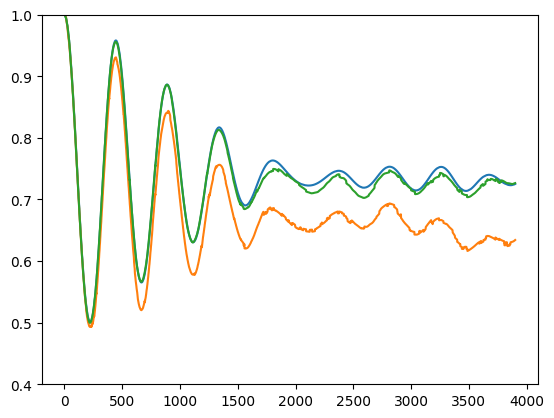

In [5]:
pops_fssh = np.real(np.einsum('nii->ni',data_fssh.data_dic['dm_db']))
ntraj = np.sum(pops_fssh[0])
pops_fssh = pops_fssh/ntraj

pops_mf = np.real(np.einsum('nii->ni',data_mf.data_dic['dm_db']))
ntraj = np.sum(pops_mf[0])
pops_mf = pops_mf/ntraj

pops_cfssh = np.real(np.einsum('nii->ni',data_cfssh.data_dic['dm_db']))
ntraj = np.sum(pops_cfssh[0])
pops_cfssh = pops_cfssh/ntraj

plt.plot(pops_mf[:,0])
plt.plot(pops_fssh[:,0])
plt.plot(pops_cfssh[:,0])
plt.ylim([0.4,1])
plt.show()